In [1]:
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, concatenate,BatchNormalization,Dropout,GlobalAveragePooling2D
from keras.models import Model
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
import cv2
from tqdm.notebook import tqdm
import pickle
from keras.callbacks import ModelCheckpoint

In [2]:
violence_optical=np.load('numpy_array\\optical_violence.npy')
violence_rgb=np.load('numpy_array\\rgb_violence.npy')
non_violence_optical=np.load('numpy_array\\non_violence_optical_1.npy')
non_violence_rgb=np.load('numpy_array\\non_violence_rgb_1.npy')

In [3]:
print(np.shape(non_violence_optical))
print(np.shape(non_violence_rgb))
print(np.shape(violence_rgb))
print(np.shape(violence_optical))

(294567, 224, 224, 3)
(294567, 224, 224, 3)
(245264, 224, 224, 3)
(245264, 224, 224, 3)


In [4]:
violence_optical_half=violence_optical[213948:245264]
violence_rgb_half=violence_rgb[213948:245264]
violence_optical=None
del violence_optical
violence_rgb=None
del violence_rgb
non_violence_optical_half=non_violence_optical[220925:294567]
non_violence_rgb_half=non_violence_rgb[220925:294567]
non_violence_optical=None
del non_violence_optical
non_violence_rgb=None
del non_violence_rgb

In [5]:
print(np.shape(non_violence_optical_half))
print(np.shape(non_violence_rgb_half))
print(np.shape(violence_rgb_half))
print(np.shape(violence_optical_half))

(73642, 224, 224, 3)
(73642, 224, 224, 3)
(31316, 224, 224, 3)
(31316, 224, 224, 3)


In [6]:
##non_violence_optical_half=np.resize(non_violence_optical_half_temp,(73642, 100, 100, 3))
##non_violence_optical_half_temp=None
##del non_violence_optical_half_temp
##print(np.shape(non_violence_optical_half))
##non_violence_rgb_half=np.resize(non_violence_rgb_half_temp,(73642, 100, 100, 3))
##non_violence_rgb_half_temp=None
##del non_violence_rgb_half_temp
##print(np.shape(non_violence_rgb_half))
##violence_rgb_half=np.resize(violence_rgb_half_temp,(61316, 100, 100, 3))
##violence_rgb_half_temp=None
##del violence_rgb_half_temp
##print(np.shape(violence_rgb_half))
##violence_optical_half=np.resize(violence_optical_half_temp,(61316, 100, 100, 3))
##violence_optical_half_temp=None
##del violence_optical_half_temp
##print(np.shape(violence_optical_half))

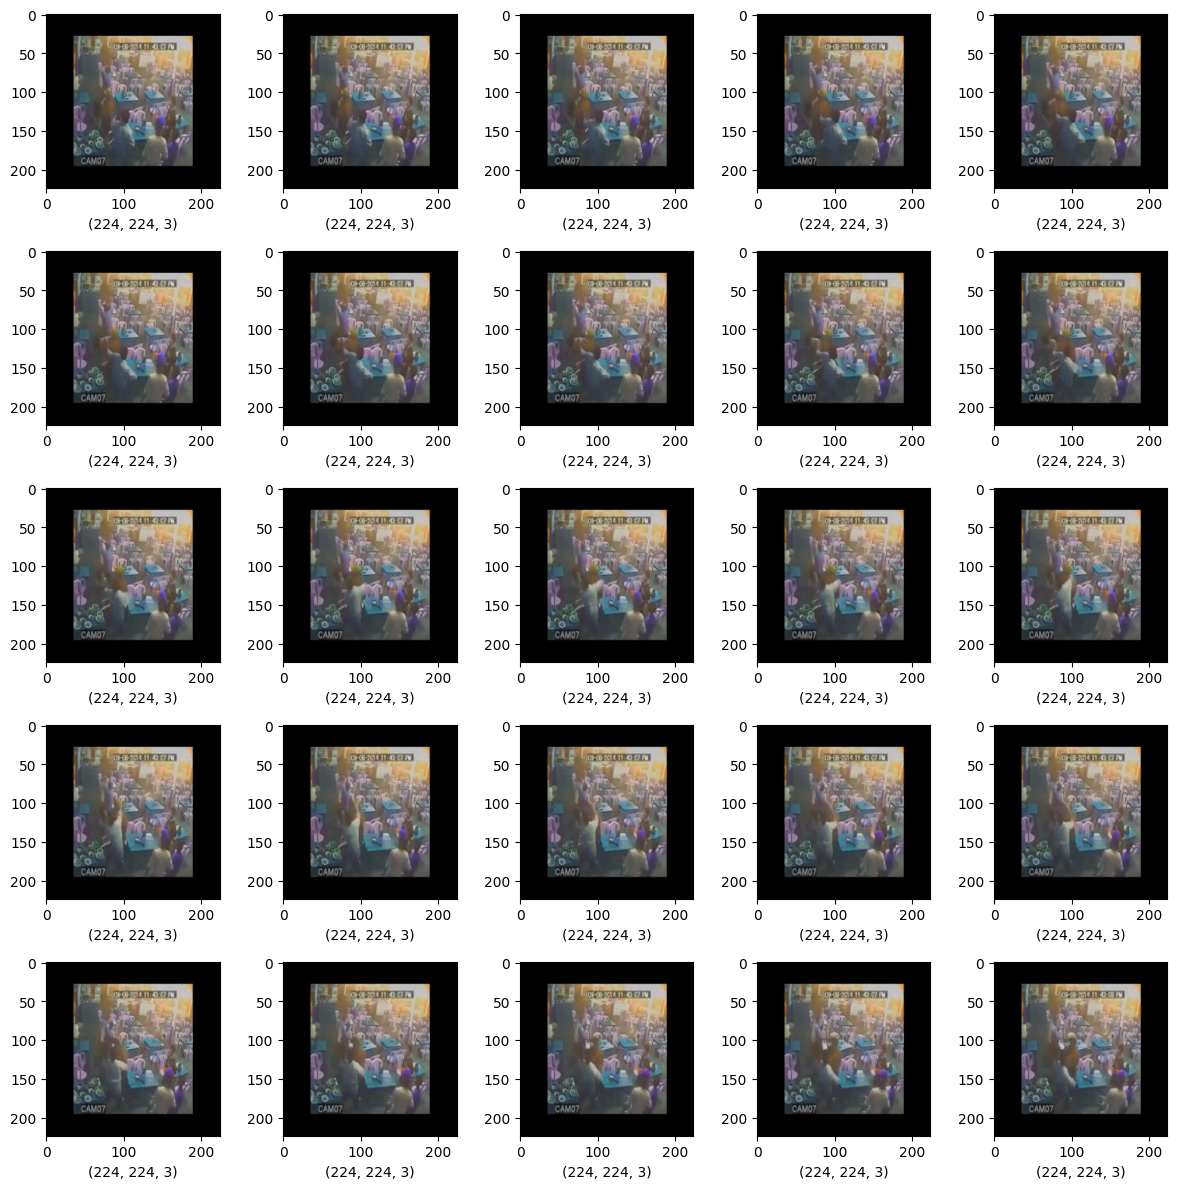

In [7]:
figure,axis = plt.subplots(5,5,figsize=(12,12))

for i,ax in enumerate(axis.flat):
    
    Img_Pick = violence_rgb_half[i]
    
    ax.set_xlabel(Img_Pick.shape)
    ax.imshow(Img_Pick)

plt.tight_layout()
plt.show()

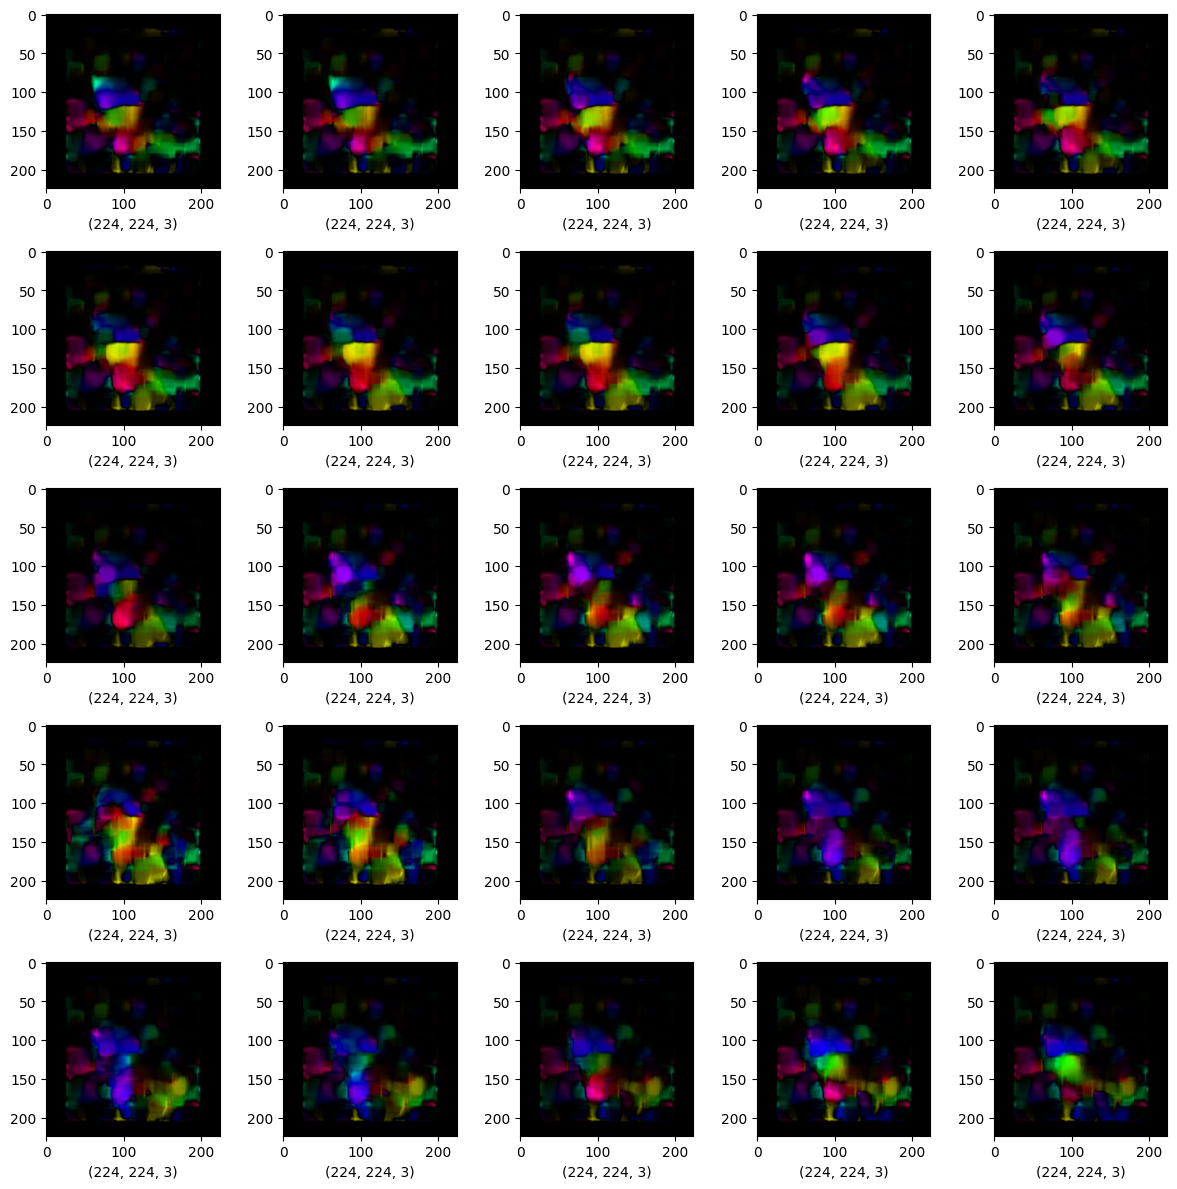

In [8]:
figure,axis = plt.subplots(5,5,figsize=(12,12))

for i,ax in enumerate(axis.flat):
    
    Img_Pick = violence_optical_half[i]
    
    ax.set_xlabel(Img_Pick.shape)
    ax.imshow(Img_Pick)

plt.tight_layout()
plt.show()

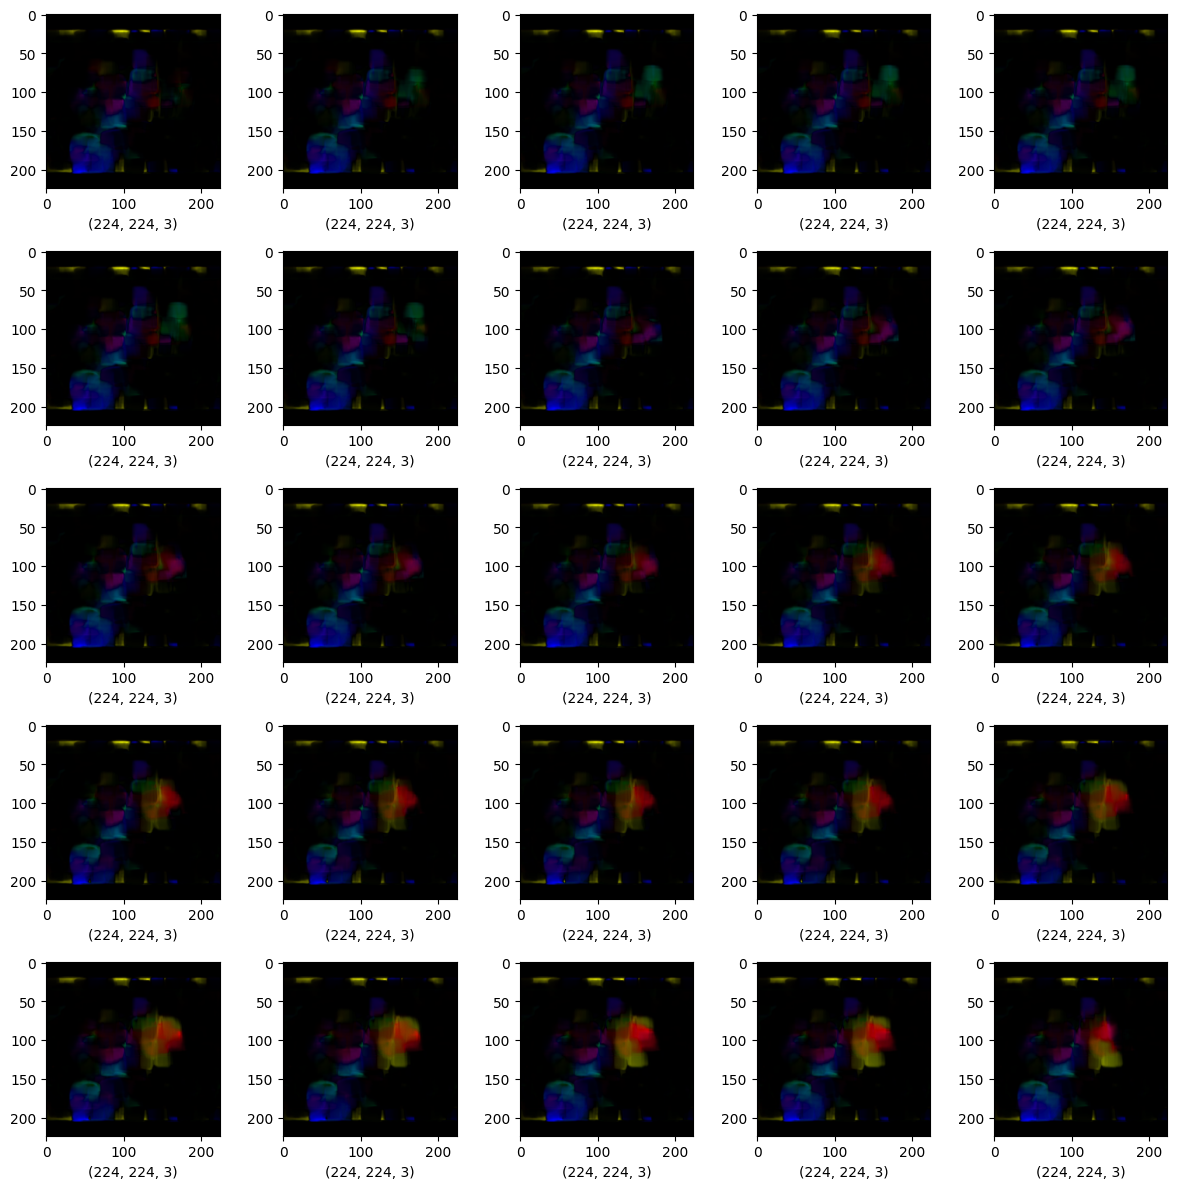

In [9]:
figure,axis = plt.subplots(5,5,figsize=(12,12))

for i,ax in enumerate(axis.flat):
    
    Img_Pick = non_violence_optical_half[i]
    
    ax.set_xlabel(Img_Pick.shape)
    ax.imshow(Img_Pick)

plt.tight_layout()
plt.show()

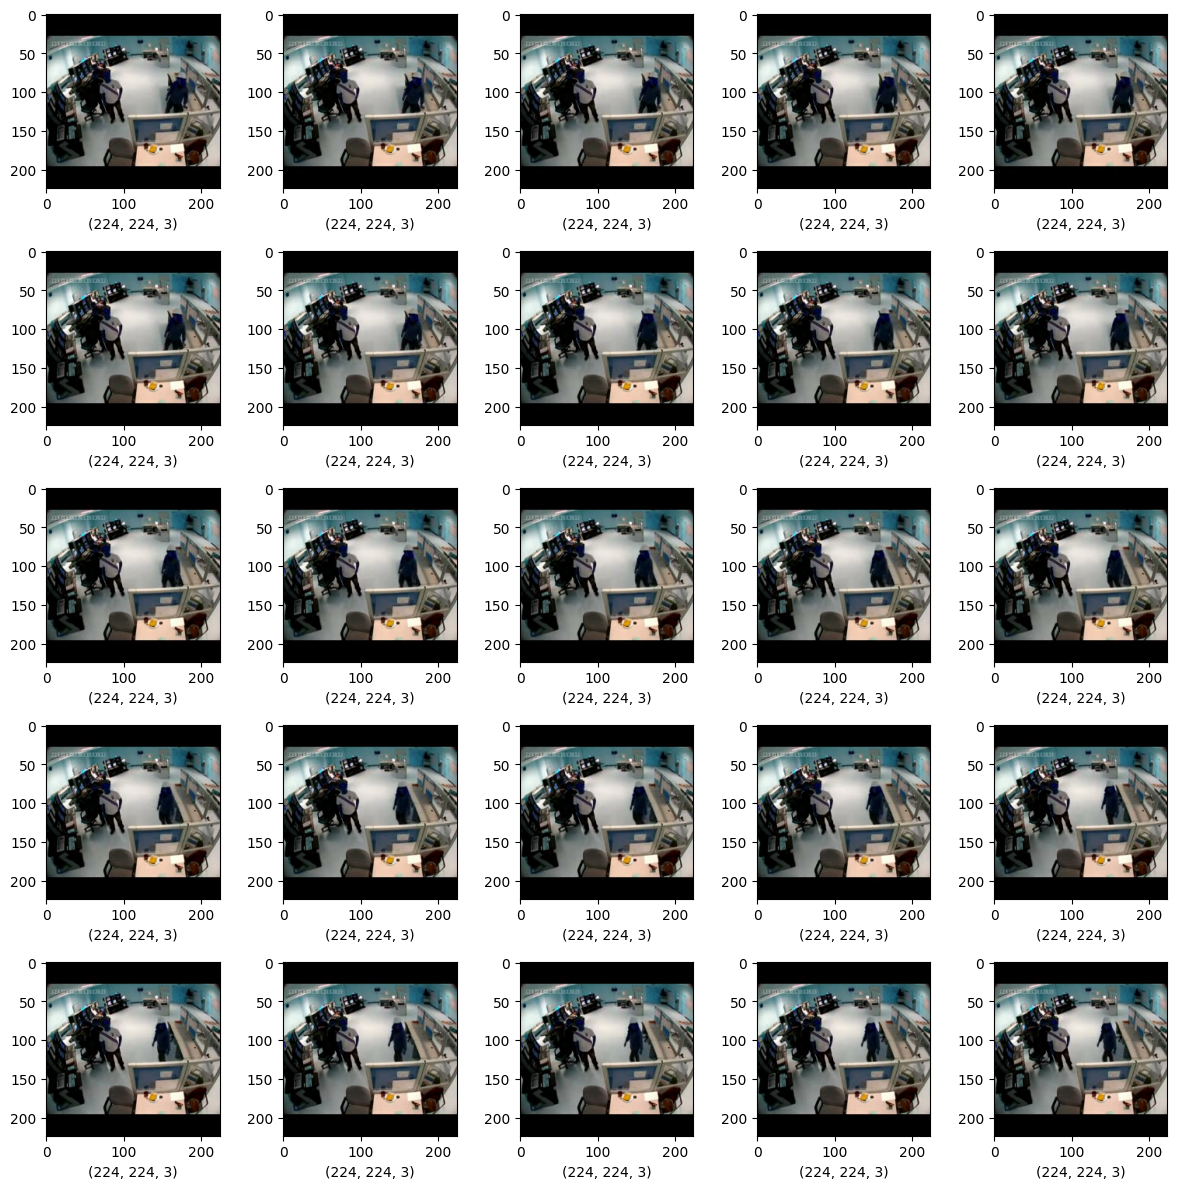

In [10]:
figure,axis = plt.subplots(5,5,figsize=(12,12))

for i,ax in enumerate(axis.flat):
    
    Img_Pick = non_violence_rgb_half[i]
    
    ax.set_xlabel(Img_Pick.shape)
    ax.imshow(Img_Pick)

plt.tight_layout()
plt.show()

In [11]:
X_4D_Violence_Labels = np.ones((31316,1))
X_4D_Violence_Labels = X_4D_Violence_Labels.flatten()
X_4D_Violence_Labels = X_4D_Violence_Labels.astype(int)
print(X_4D_Violence_Labels)

[1 1 1 ... 1 1 1]


In [12]:
X_4D_NonViolence_Labels = np.zeros((73642,1))
X_4D_NonViolence_Labels = X_4D_NonViolence_Labels.flatten()
X_4D_NonViolence_Labels = X_4D_NonViolence_Labels.astype(int)
print(X_4D_NonViolence_Labels)

[0 0 0 ... 0 0 0]


In [13]:
X_Train_optical = np.concatenate((violence_optical_half,non_violence_optical_half),axis=0)
print(np.shape(X_Train_optical))

(164956, 224, 224, 3)


In [14]:
violence_optical_half=None
del violence_optical_half
non_violence_optical_half=None
del non_violence_optical_half

In [15]:
X_Train_rgb = np.concatenate((violence_rgb_half,non_violence_rgb_half),axis=0)
print(np.shape(X_Train_rgb))

(164956, 224, 224, 3)


In [16]:
violence_rgb_half=None
del violence_rgb_half
non_violence_rgb_half=None
del non_violence_rgb_half

In [17]:
Y_Train = np.concatenate((X_4D_Violence_Labels,X_4D_NonViolence_Labels),axis=0)

In [18]:
from sklearn.model_selection import train_test_split
X_train_op,X_test_op,y_train_1,y_test_1=train_test_split(X_Train_optical,Y_Train,random_state=42,test_size=0.2,shuffle=True)
X_Train_optical=None
del X_Train_optical
X_train_rg,X_test_rg,y_train,y_test=train_test_split(X_Train_rgb,Y_Train,random_state=42,test_size=0.2,shuffle=True)
X_Train_rgb=None
del X_Train_rgb

In [19]:
rgb_input_shape=(224,224,3)
flow_input_shape=(224,224,3)

In [20]:
spatial_input = Input(shape=rgb_input_shape)
temporal_input=Input(shape=flow_input_shape)

In [21]:
x=Conv2D(128,kernel_size=(7,7),strides=2,activation='relu')(spatial_input)
x=MaxPooling2D(pool_size=(2,2))(x)
x=Conv2D(64,kernel_size=(5,5,),activation='relu',strides=2)(x)
x=MaxPooling2D(pool_size=(2,2))(x)
x=Conv2D(32,kernel_size=(3,3),strides=1,activation='relu')(x)
spatial_output=Conv2D(16,kernel_size=(3,3),strides=1,activation='relu')(x)
#spatial_output = Dense(1, activation='sigmoid')(x)
spatial_model = Model(inputs=spatial_input, outputs=spatial_output)

In [22]:
#temporal model
y=Conv2D(128,kernel_size=(7,7),strides=2,activation='relu')(temporal_input)
y=MaxPooling2D(pool_size=(2,2))(y)
y=Conv2D(64,kernel_size=(5,5,),activation='relu',strides=2)(y)
y=MaxPooling2D(pool_size=(2,2))(y)
y=Conv2D(32,kernel_size=(3,3),strides=1,activation='relu')(y)
temporal_output=Conv2D(16,kernel_size=(3,3),strides=1,activation='relu')(y)
#temporal_output = Dense(1, activation='sigmoid')(y)
temporal_model = Model(inputs=temporal_input, outputs=temporal_output)

In [23]:
combined_input = concatenate([spatial_model.output, temporal_model.output])
z=GlobalAveragePooling2D()(combined_input)
z=Dense(32,activation='relu')(z)
z=Dense(8,activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)
final_model = Model(inputs=[spatial_model.input, temporal_model.input], outputs=z)

In [24]:
from keras.optimizers import SGD
opt = SGD(lr=0.0000001)
final_model.compile(loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="auto",
    name="binary_crossentropy",
),metrics=["accuracy"], optimizer = opt)

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 12  18944       ['input_1[0][0]']                
                                8)                                                          

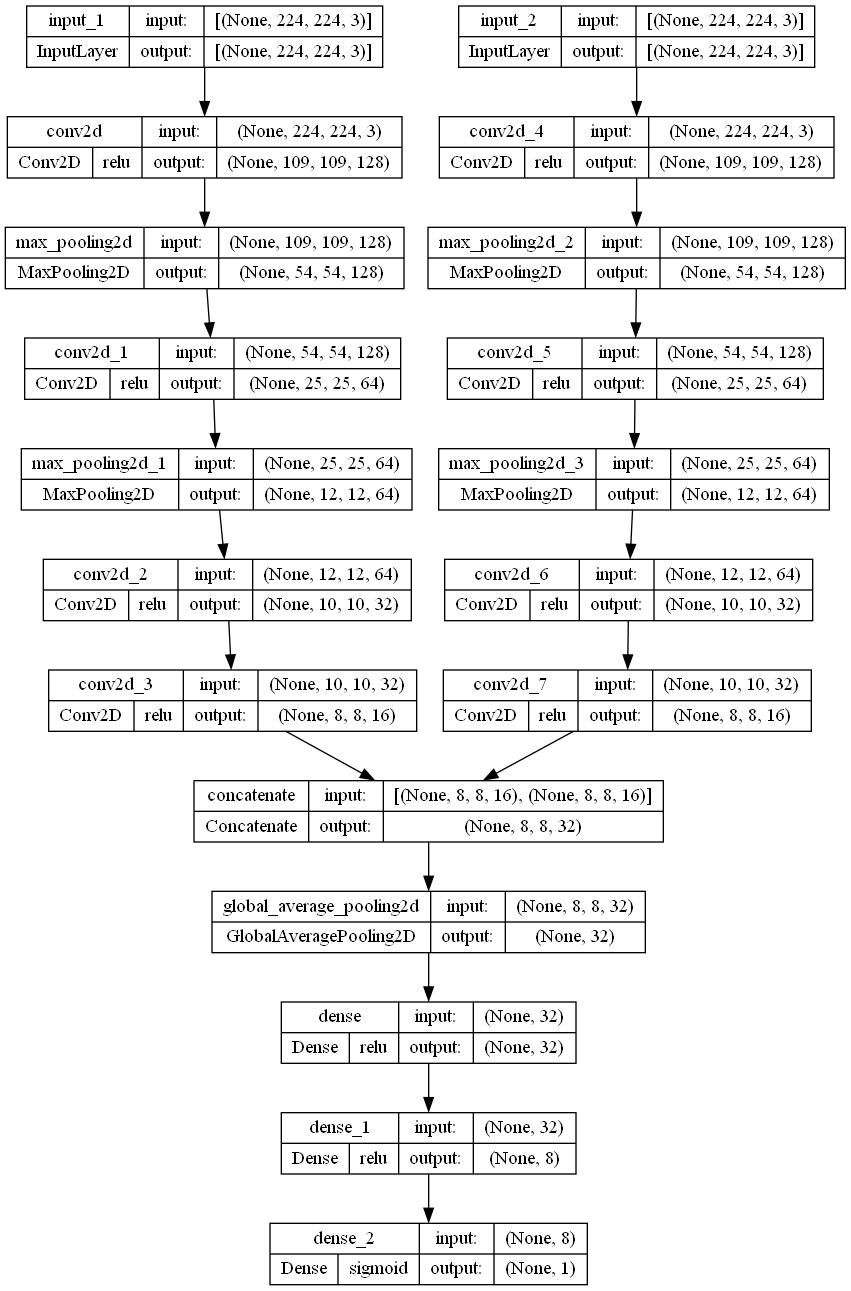

In [26]:
keras.utils.plot_model(
    final_model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [27]:
Callback_Stop_Early = keras.callbacks.EarlyStopping(monitor="val_loss",patience=10, mode="auto")

Epoch 1/50
3712/3712 [==============================] - 201s 45ms/step - loss: 1.1729 - accuracy: 0.5398 - val_loss: 0.9002 - val_accuracy: 0.5477
Epoch 2/50
3712/3712 [==============================] - 162s 44ms/step - loss: 0.8347 - accuracy: 0.5479 - val_loss: 0.7762 - val_accuracy: 0.5584
Epoch 3/50
3712/3712 [==============================] - 165s 44ms/step - loss: 0.7494 - accuracy: 0.5629 - val_loss: 0.7210 - val_accuracy: 0.5786
Epoch 4/50
3712/3712 [==============================] - 165s 44ms/step - loss: 0.7075 - accuracy: 0.5827 - val_loss: 0.6903 - val_accuracy: 0.6014
Epoch 5/50
3712/3712 [==============================] - 166s 45ms/step - loss: 0.6821 - accuracy: 0.6036 - val_loss: 0.6706 - val_accuracy: 0.6204
Epoch 6/50
3712/3712 [==============================] - 167s 45ms/step - loss: 0.6645 - accuracy: 0.6201 - val_loss: 0.6561 - val_accuracy: 0.6348
Epoch 7/50
3712/3712 [==============================] - 166s 45ms/step - loss: 0.6513 - accuracy: 0.6329 - val_loss: 0

<Axes: >

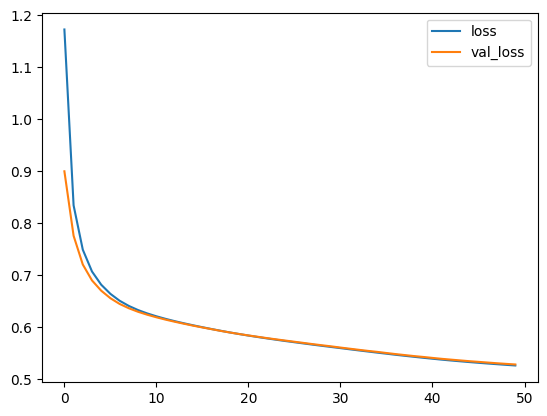

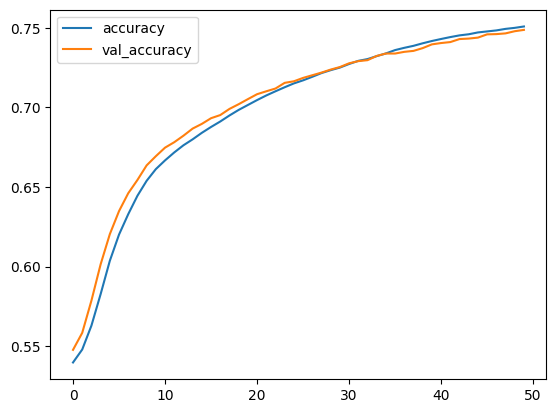

In [28]:
history= final_model.fit([X_train_rg, X_train_op], y_train,
                    batch_size=32, epochs=50,shuffle=True,callbacks=[Callback_Stop_Early,ModelCheckpoint('model.h5',save_best_only=True,monitor="val_loss",mode="auto")],validation_split=0.1)
history=pd.DataFrame(history.history)
history.loc[:,['loss','val_loss']].plot()
history.loc[:,['accuracy','val_accuracy']].plot()

In [ ]:
final_model.evaluate([X_test_op,X_test_rg],y_test)

In [30]:
final_model.save('model.h5')